In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr

from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import pdist
import os
import optuna

import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import cross_val_score


from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("Breast_GSE45827.csv")


### Sections
 - EDA 
 - Genes selection using MI and Stat test
 - Visualization of data using selected genes
 - Logistic Regression for genes importances
 - Conclusion
 

## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), int64(1), object(1)
memory usage: 63.0+ MB


In [5]:
df.head(5)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


In [6]:
df.notnull().count()

samples            151
type               151
1007_s_at          151
1053_at            151
117_at             151
                  ... 
AFFX-ThrX-5_at     151
AFFX-ThrX-M_at     151
AFFX-TrpnX-3_at    151
AFFX-TrpnX-5_at    151
AFFX-TrpnX-M_at    151
Length: 54677, dtype: int64

In [7]:
df.notnull().count().min(), df.notnull().count().max()

(151, 151)

In [8]:
genes_matrix = df.drop(["samples", "type"], axis=1).values
genes_names = df.columns[2:]




color_map = {
    "normal": "#2ca02c",  # Olive green, good for 'normal' to symbolize health
    "HER": "#1f77b4",    # Mutated blue, a stark contrast for highlighting HER
    "luminal_B": "#9467bd",  # Soft purple, distinct yet clearly differentiable
    "luminal_A": "#8c564b",  # Rosy brown, subtle and distinct from luminal_B
    "cell_line": "#ff7f0e",  # Bright orange, stands out for 'cell line'
    "basal": "#d62728"     # Strong red, impactful for highlighting 'basal'
}


cancer_labels = df["type"].values
type_encoder = { t: i for i, t in enumerate(color_map.keys())}

labels = [type_encoder[t] for t in cancer_labels]



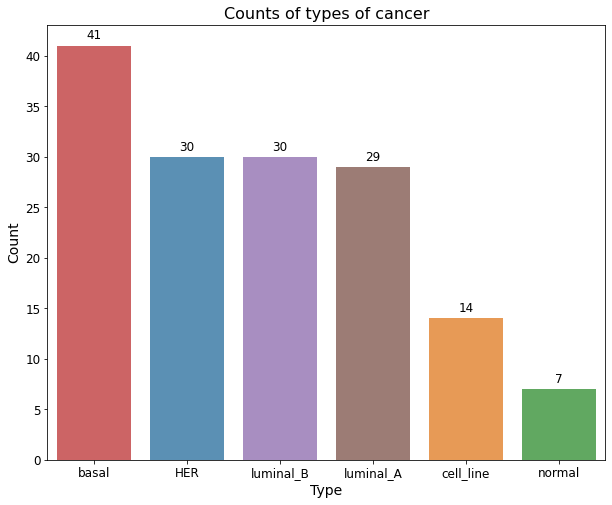

In [9]:
plt.figure(figsize=(10, 8))

value_counts = df["type"].value_counts().reset_index()
value_counts.columns = ['type', 'count']


ax = sns.barplot(x='type', y='count', data=value_counts, palette=color_map, hue="type", alpha=0.8)
ax.set_title('Counts of types of cancer', fontsize=16)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(labelsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)


plt.show()


In [10]:
print("Min value of gene expression is ", genes_matrix.min())
print("Max value of gene expression is ", genes_matrix.max())
print("Total variance in gene matrix is ", genes_matrix.var())

Min value of gene expression is  2.17109972663613
Max value of gene expression is  14.9701002149474
Total variance in gene matrix is  4.526885278734545


## PCA


In [11]:
%%time

#using PCA to see how many companents we need to achieve good explained variance

pca = PCA(n_components=100)
pca.fit(genes_matrix)

CPU times: user 13.5 s, sys: 5.58 s, total: 19.1 s
Wall time: 5.43 s


PCA(n_components=100)

In [12]:
%%time 

genes_matrix_pca = pca.transform(genes_matrix)

CPU times: user 405 ms, sys: 217 ms, total: 623 ms
Wall time: 239 ms


In [13]:
genes_matrix_pca.shape

(151, 100)

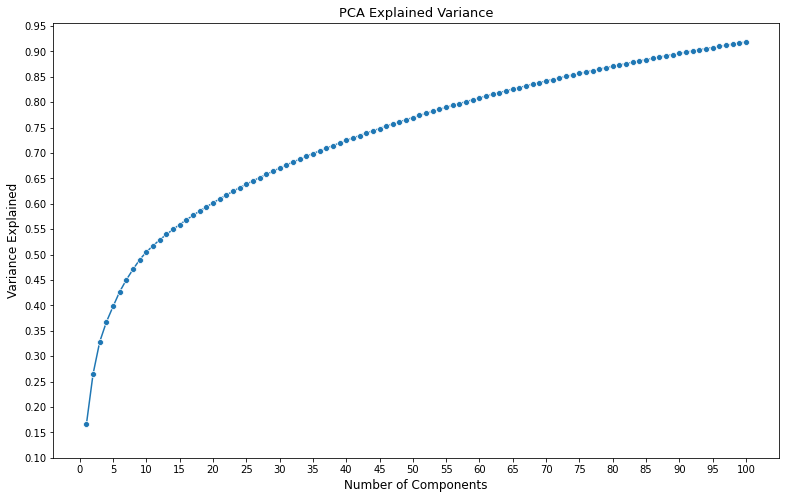

In [14]:
plt.figure(figsize=(13, 8))
sns.lineplot(x=np.arange(1, pca.n_components_ + 1, 1), y=np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title('PCA Explained Variance', fontsize=13)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Variance Explained', fontsize=12)
plt.xticks(np.arange(0, 105, 5))
plt.yticks(np.arange(0.1, 1, 0.05))
plt.show()

In [15]:
print("ratio of VAR explained by  first 100 PCs = ", np.sum(pca.explained_variance_ratio_))

ratio of VAR explained by  first 100 PCs =  0.9183386568693958


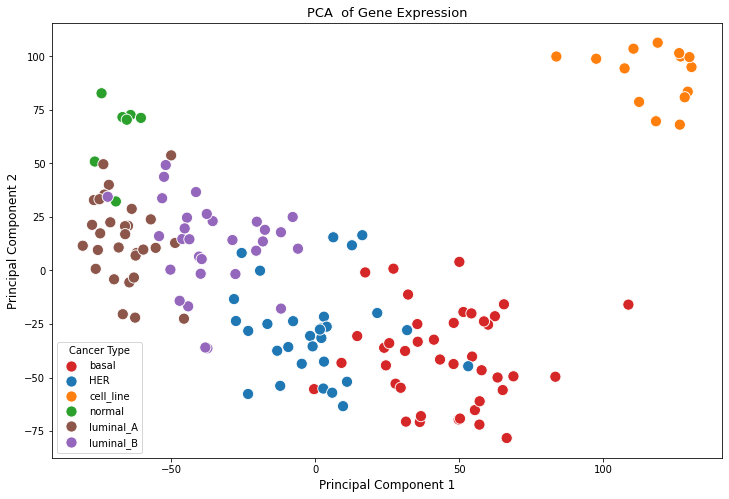

In [17]:
pca_df = pd.DataFrame(genes_matrix_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA  of Gene Expression', fontsize=13)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

## T-SNE visualization

In [20]:

tsne = TSNE(n_components=2,
            init="pca",
            random_state=1
            )





genes_matrix_tsne = tsne.fit_transform(genes_matrix)

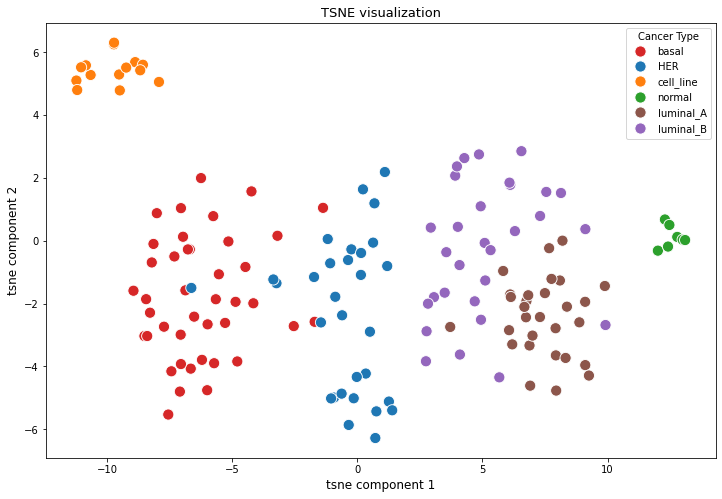

In [21]:
tsne_df = pd.DataFrame(genes_matrix_tsne[:, :2], columns=['PCA1', 'PCA2'])
tsne_df['Label'] = cancer_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('TSNE visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

TSNE separates classes much better

## Gene selection

### Mutual Information

In [23]:
%%time




mi_scores = mutual_info_classif(genes_matrix, labels, random_state=1)

In [24]:
mi_df = pd.read_csv("genes_MI.csv").drop("Unnamed: 0", axis=1)

In [22]:

mi_df = pd.DataFrame({"gene" : genes_names, 
                     "MI" : mi_scores})

mi_df = mi_df.sort_values(by="MI", ascending=False)

mi_df.to_csv("genes_MI.csv")


mi_df.head(10)

,gene,MI
20845,211519_s_at,0.917965
19457,210052_s_at,0.866330
11688,202240_at,0.845233
27827,218542_at,0.845002
12227,202779_s_at,0.819782
32506,223229_at,0.806840
13609,204162_at,0.806807
19051,209642_at,0.803727
34448,225191_at,0.802138
18877,209464_at,0.792221


In [25]:
mi_df["MI"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999])

0.100    0.016808
0.200    0.051215
0.300    0.078727
0.400    0.104878
0.500    0.132005
0.600    0.161793
0.700    0.197437
0.800    0.245639
0.900    0.321369
0.950    0.392730
0.990    0.539691
0.999    0.704228
Name: MI, dtype: float64

In [24]:
###a lot of features have very low MI


### Chi-Squared statistic

In [26]:
%%time 

chi2_scores, chi2_pvals = chi2(genes_matrix, labels)

chi2_df = pd.DataFrame({"gene" : genes_names, 
                     "CHI2" : chi2_scores,
                      "p_value" : chi2_pvals})

chi2_df = chi2_df.sort_values(by="CHI2", ascending=False)

chi2_df.to_csv("genes_chi2.csv")


chi2_df.head(10)

CPU times: user 535 ms, sys: 302 ms, total: 837 ms
Wall time: 544 ms


,gene,CHI2,p_value
37495,228241_at,214.481735,2.258643e-44
46588,237339_at,146.800900,6.402447e-30
15824,206378_at,145.705457,1.094978e-29
14672,205225_at,135.837039,1.371714e-27
18587,209173_at,128.352468,5.322940e-26
14456,205009_at,122.070630,1.143046e-24
37808,228554_at,118.543040,6.386788e-24
14491,205044_at,118.189847,7.586930e-24
33137,223861_at,116.467687,1.756418e-23
46335,237086_at,111.836230,1.676334e-22


#### TODO:
- drop all features that have both lower CHI2 and MI

## Filtering genes

In [27]:
#### selecting only features that have Mutual Information  >= 0.5

mi_selected_genes = mi_df[mi_df["MI"] >= 0.5]

mi_selected_genes

,gene,MI
0,211519_s_at,0.917965
1,210052_s_at,0.866330
2,202240_at,0.845233
3,218542_at,0.845002
4,202779_s_at,0.819782
...,...,...
853,227020_at,0.500298
854,220036_s_at,0.500290
855,1555943_at,0.500095
856,235847_at,0.500090


In [28]:
### selecting genes with chi2 pvalue  < 0.01

chi2_selected_genes  = chi2_df[chi2_df["p_value"] < 0.01]
chi2_selected_genes

,gene,CHI2,p_value
37495,228241_at,214.481735,2.258643e-44
46588,237339_at,146.800900,6.402447e-30
15824,206378_at,145.705457,1.094978e-29
14672,205225_at,135.837039,1.371714e-27
18587,209173_at,128.352468,5.322940e-26
...,...,...,...
40494,231240_at,15.142027,9.772410e-03
21562,212256_at,15.129888,9.821529e-03
34977,225720_at,15.126729,9.834351e-03
24597,215303_at,15.124315,9.844158e-03


In [29]:
selected_genes = list(set(list(mi_selected_genes["gene"]) + list(chi2_selected_genes["gene"])))


genes_selected_both = list(set(mi_selected_genes["gene"]) & set(chi2_selected_genes["gene"]))

print("Number of genes selected by both MI and Chi2:", len(genes_selected_both))
print("Number of genes selected by either MI or Chi2: ",len(selected_genes))

##The most valuable are probably from interesection
genes_selected_both[:10]

Number of genes selected by both MI and Chi2: 416
Number of genes selected by either MI or Chi2:  2194


['218353_at',
 '221561_at',
 '226597_at',
 '204667_at',
 '1555758_a_at',
 '219233_s_at',
 '223121_s_at',
 '222608_s_at',
 '228559_at',
 '229538_s_at']

### try  to visualize using only very important genes

#### PCA on selected genes

In [30]:
genes_matrix_reduced = df[genes_selected_both].values

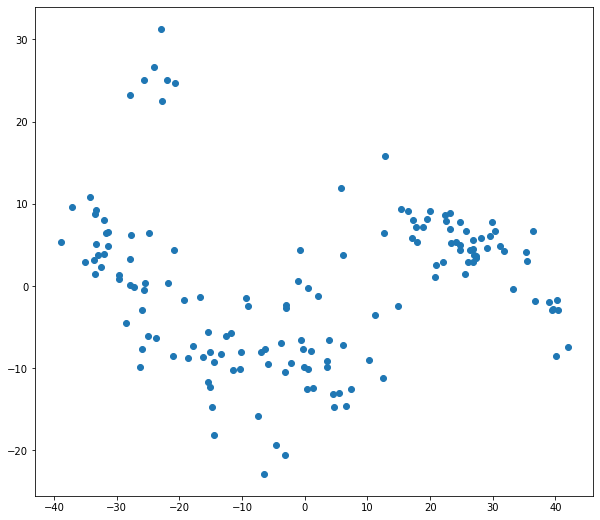

In [31]:
pca_red = PCA(n_components=2)



genes_matrix_reduced_pca = pca_red.fit_transform(genes_matrix_reduced)


plt.figure(figsize=(10, 9))
plt.scatter(genes_matrix_reduced_pca.T[0], genes_matrix_reduced_pca.T[1])

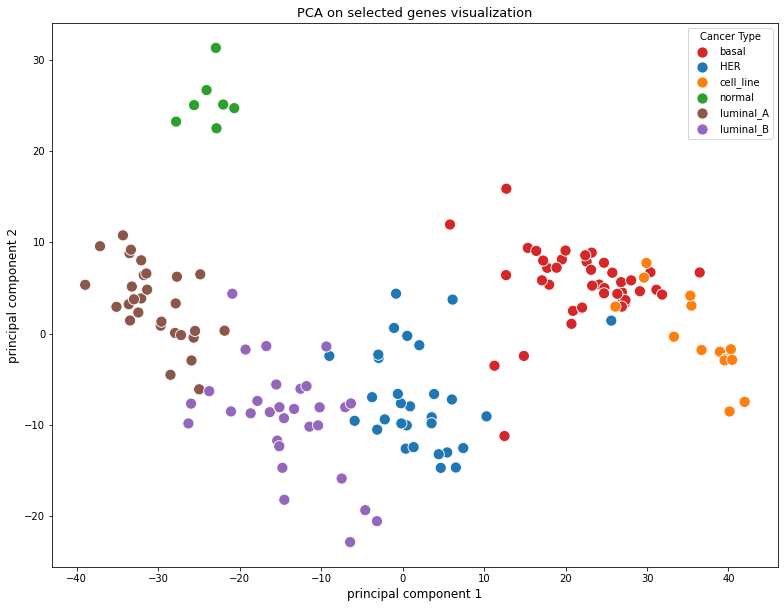

In [32]:
pca_red_df = pd.DataFrame(genes_matrix_reduced_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=pca_red_df, x='PCA1', y='PCA2', hue='Label', palette=color_map, s=125)

plt.title('PCA on selected genes visualization', fontsize=13)
plt.xlabel('principal component 1', fontsize=12)
plt.ylabel('principal component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### TSNE on selected genes

In [33]:
tsne_red = TSNE(n_components=2,
            init="pca",
            random_state=1
            )


genes_matrix_reduced_tsne = tsne_red.fit_transform(genes_matrix_reduced)

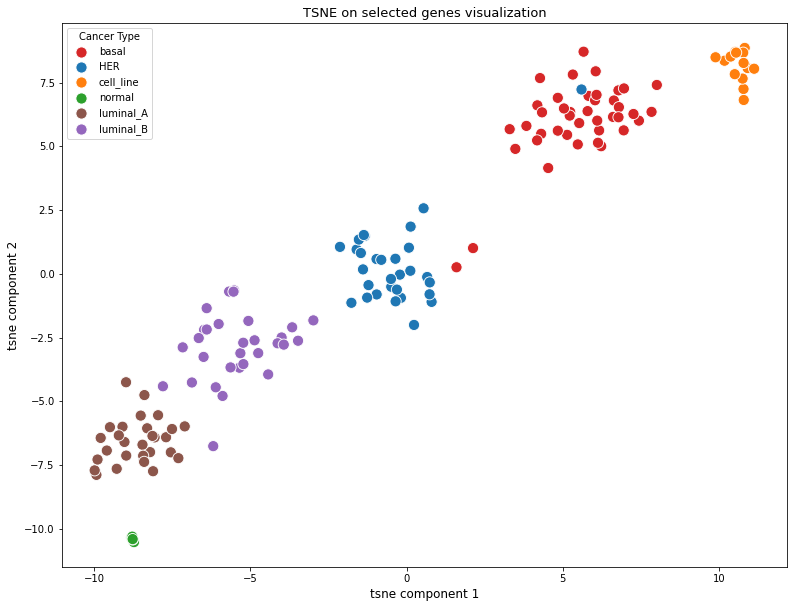

In [58]:
tsne_red_df = pd.DataFrame(genes_matrix_reduced_tsne[:, :2], columns=['axis1', 'axis2'])
tsne_red_df['Label'] = cancer_labels

plt.figure(figsize=(13, 10))
sns.scatterplot(data=tsne_red_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=125)

plt.title('TSNE on selected genes visualization', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

### Tuning T-SNE hyperparameters

In [55]:
def compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=5):
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high_dim)
    _, indices_high = nn_high.kneighbors(X_high_dim)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low_dim)
    _, indices_low = nn_low.kneighbors(X_low_dim)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(X_high_dim) * n_neighbors)
    return score

def compute_KNC_score(X_high_dim, X_low_dim, labels, n_neighbors=5):
    classes = np.unique(labels)
    means_high = np.array([X_high_dim[labels == c].mean(axis=0) for c in classes])
    means_low = np.array([X_low_dim[labels == c].mean(axis=0) for c in classes])
    
    nn_high = NearestNeighbors(n_neighbors=n_neighbors).fit(means_high)
    _, indices_high = nn_high.kneighbors(means_high)
    
    nn_low = NearestNeighbors(n_neighbors=n_neighbors).fit(means_low)
    _, indices_low = nn_low.kneighbors(means_low)
    
    score = sum(len(set(high).intersection(set(low))) for high, low in zip(indices_high, indices_low)) / (len(classes) * n_neighbors)
    return score

def compute_CPD_score(X_high_dim, X_low_dim):
    distances_high = pdist(X_high_dim, 'euclidean')
    distances_low = pdist(X_low_dim, 'euclidean')
    
    correlation, _ = spearmanr(distances_high, distances_low)
    return correlation

In [40]:



def save_tsne_plot(X_low_dim, labels, trial_id):
    plt.figure(figsize=(8, 6))
    for i in np.unique(labels):
        plt.scatter(X_low_dim[labels == i, 0], X_low_dim[labels == i, 1], label=i)
    plt.title(f't-SNE Visualization Trial {trial_id}')
    plt.legend()
    plt.savefig(f'tsne_trials/trial_{trial_id}.png')
    plt.close()

def objective(trial):
    X_high_dim = genes_matrix_reduced
    y = labels
    n_classes = len(np.unique(y))
    
    ##TSNE PARAMS
    perplexity = trial.suggest_float('perplexity', 5, 50)
    learning_rate = trial.suggest_float('learning_rate', 10, 1000)
    n_iter = trial.suggest_int('n_iter', 250, 5000)
    early_exaggeration= trial.suggest_int("early_exaggeration", 1, 20)
    
    
    
    tsne = TSNE(perplexity=perplexity,
                learning_rate=learning_rate,
                n_iter=n_iter,
                early_exaggeration = early_exaggeration,
                random_state=42)
    X_low_dim = tsne.fit_transform(X_high_dim)
    
    knn_score = compute_KNN_score(X_high_dim, X_low_dim, n_neighbors=4) #microscopic structure
    knc_score = compute_KNC_score(X_high_dim, X_low_dim, y, n_neighbors=n_classes) 
    cpd_score = compute_CPD_score(X_high_dim, X_low_dim) #Global structure
    
    average_score = (0.8 * knn_score + knc_score +  1.2 * cpd_score) / 3
    save_tsne_plot(X_low_dim, y, trial.number)
    return average_score


os.makedirs('tsne_trials', exist_ok=True)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)




[I 2024-02-12 20:51:43,571] A new study created in memory with name: no-name-daea5685-de08-4a3d-a4d8-5ce124fbcfb8
[I 2024-02-12 20:51:44,718] Trial 0 finished with value: 0.8594261337713389 and parameters: {'perplexity': 16.0526142662008, 'learning_rate': 650.37149326995, 'n_iter': 2473, 'early_exaggeration': 8}. Best is trial 0 with value: 0.8594261337713389.
[I 2024-02-12 20:51:46,490] Trial 1 finished with value: 0.8646602352669204 and parameters: {'perplexity': 29.907442879525476, 'learning_rate': 686.126800215547, 'n_iter': 1902, 'early_exaggeration': 3}. Best is trial 1 with value: 0.8646602352669204.
[I 2024-02-12 20:51:48,412] Trial 2 finished with value: 0.8996468064087271 and parameters: {'perplexity': 8.889773786183166, 'learning_rate': 123.52885256382307, 'n_iter': 2701, 'early_exaggeration': 3}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:51:49,348] Trial 3 finished with value: 0.8928352862679828 and parameters: {'perplexity': 17.1796720331579, 'learni

[I 2024-02-12 20:52:31,927] Trial 32 finished with value: 0.8953846435190388 and parameters: {'perplexity': 12.167609951772238, 'learning_rate': 172.48273300039244, 'n_iter': 1170, 'early_exaggeration': 4}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:32,895] Trial 33 finished with value: 0.8713870535977931 and parameters: {'perplexity': 7.454750824907597, 'learning_rate': 70.2232645048037, 'n_iter': 526, 'early_exaggeration': 2}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:34,667] Trial 34 finished with value: 0.892094050960777 and parameters: {'perplexity': 15.61702440146422, 'learning_rate': 15.887131524189273, 'n_iter': 1803, 'early_exaggeration': 3}. Best is trial 2 with value: 0.8996468064087271.
[I 2024-02-12 20:52:35,669] Trial 35 finished with value: 0.8889837084220268 and parameters: {'perplexity': 17.968764189866324, 'learning_rate': 127.61308351715367, 'n_iter': 888, 'early_exaggeration': 7}. Best is trial 2 with value: 0.89964

In [41]:
study.best_params

{'perplexity': 6.952086000724197,
 'learning_rate': 323.8851846729418,
 'n_iter': 3954,
 'early_exaggeration': 1}

In [43]:
tsne_tuned = TSNE(**study.best_params, random_state=42)

tuned_tsne_matrix = tsne_tuned.fit_transform(genes_matrix_reduced)

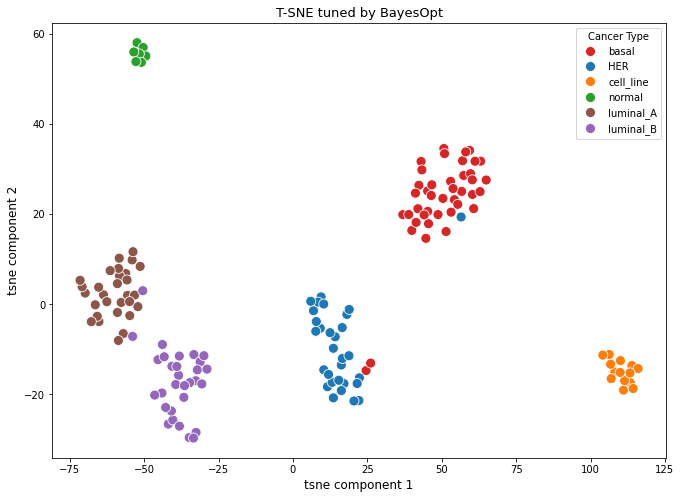

In [57]:
tuned_tsne_df = pd.DataFrame(tuned_tsne_matrix[:, :2], columns=['axis1', 'axis2'])
tuned_tsne_df['Label'] = cancer_labels

plt.figure(figsize=(11, 8))
sns.scatterplot(data=tuned_tsne_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=100)

plt.title('T-SNE tuned by BayesOpt', fontsize=13)
plt.xlabel('tsne component 1', fontsize=12)
plt.ylabel('tsne component 2', fontsize=12)
plt.legend(title='Cancer Type')
plt.show()

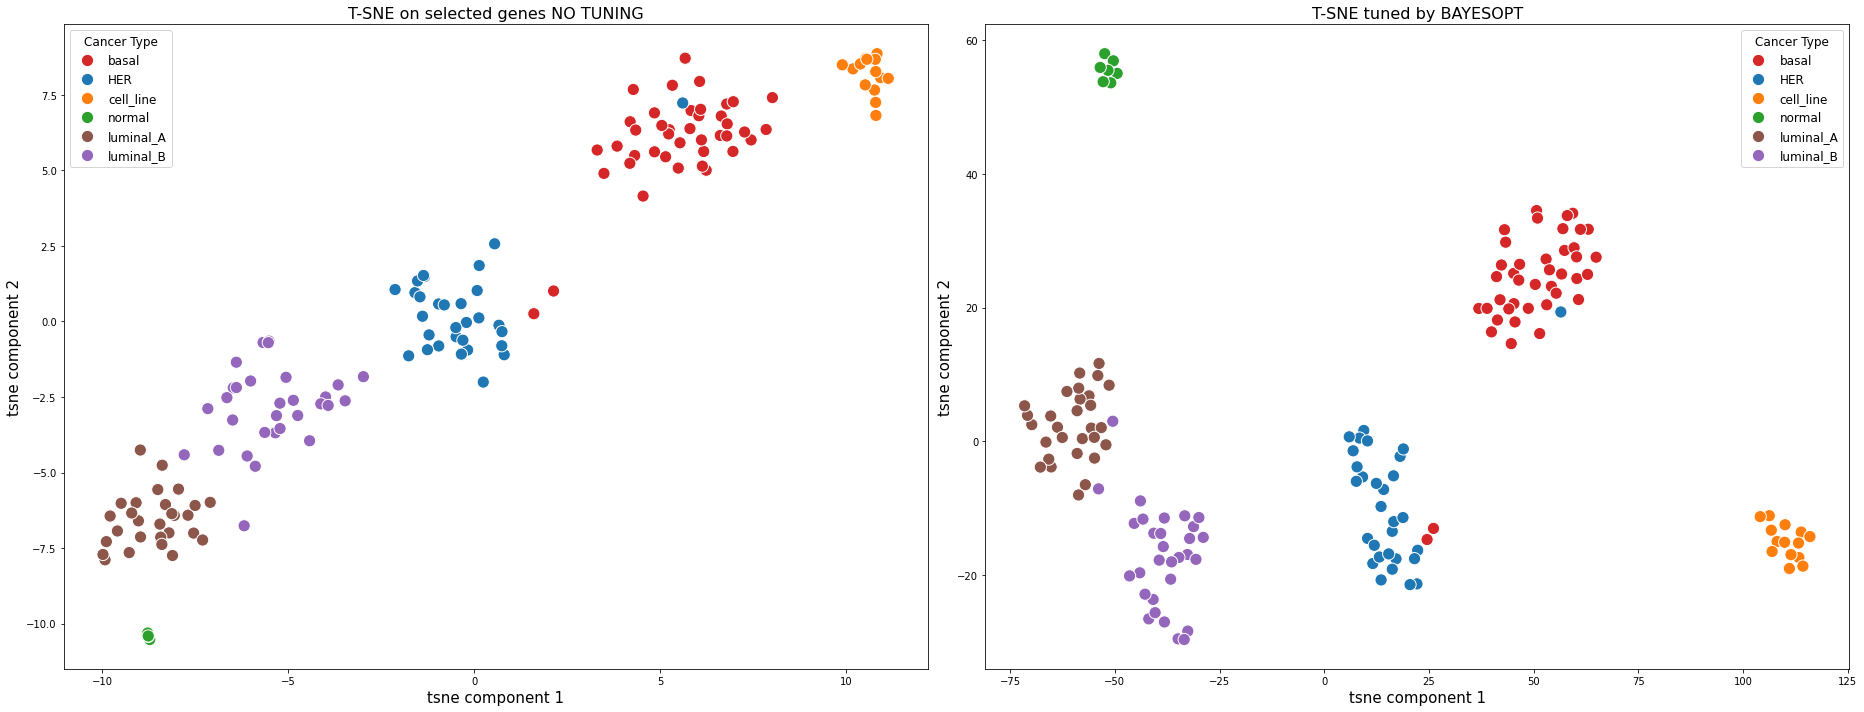

In [59]:
tuned_tsne_df = pd.DataFrame(tuned_tsne_matrix[:, :2], columns=['axis1', 'axis2'])
tuned_tsne_df['Label'] = cancer_labels

fig, axes = plt.subplots(1, 2, figsize=(26, 10))

sns.scatterplot(data=tsne_red_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=150, ax=axes[0])
axes[0].set_title('T-SNE on selected genes NO TUNING', fontsize=16)
axes[0].set_xlabel('tsne component 1', fontsize=15)
axes[0].set_ylabel('tsne component 2', fontsize=15)
axes[0].legend(title='Cancer Type', title_fontsize='large', fontsize='large')

sns.scatterplot(data=tuned_tsne_df, x='axis1', y='axis2', hue='Label', palette=color_map, s=150, ax=axes[1])
axes[1].set_title('T-SNE tuned by BAYESOPT', fontsize=16)
axes[1].set_xlabel('tsne component 1', fontsize=15)
axes[1].set_ylabel('tsne component 2', fontsize=15)
axes[1].legend(title='Cancer Type', title_fontsize='large', fontsize='large')

plt.tight_layout()
plt.show()

## Logistic Regression



In [62]:
logreg = LogisticRegression(penalty="l1",
                            solver="saga",
                            multi_class="ovr",
                            random_state=1
                            )
logreg.fit(genes_matrix_reduced, labels)

LogisticRegression(multi_class='ovr', penalty='l1', random_state=1,
                   solver='saga')

In [63]:
#Extract most important genes



her_coeffs = logreg.coef_[1]
lumB_coeffs = logreg.coef_[2]
lumA_coeffs = logreg.coef_[3]
cellline_coeffs = logreg.coef_[4]
basal_coeffs = logreg.coef_[5]



In [66]:
color_map

{'normal': '#2ca02c',
 'HER': '#1f77b4',
 'luminal_B': '#9467bd',
 'luminal_A': '#8c564b',
 'cell_line': '#ff7f0e',
 'basal': '#d62728'}

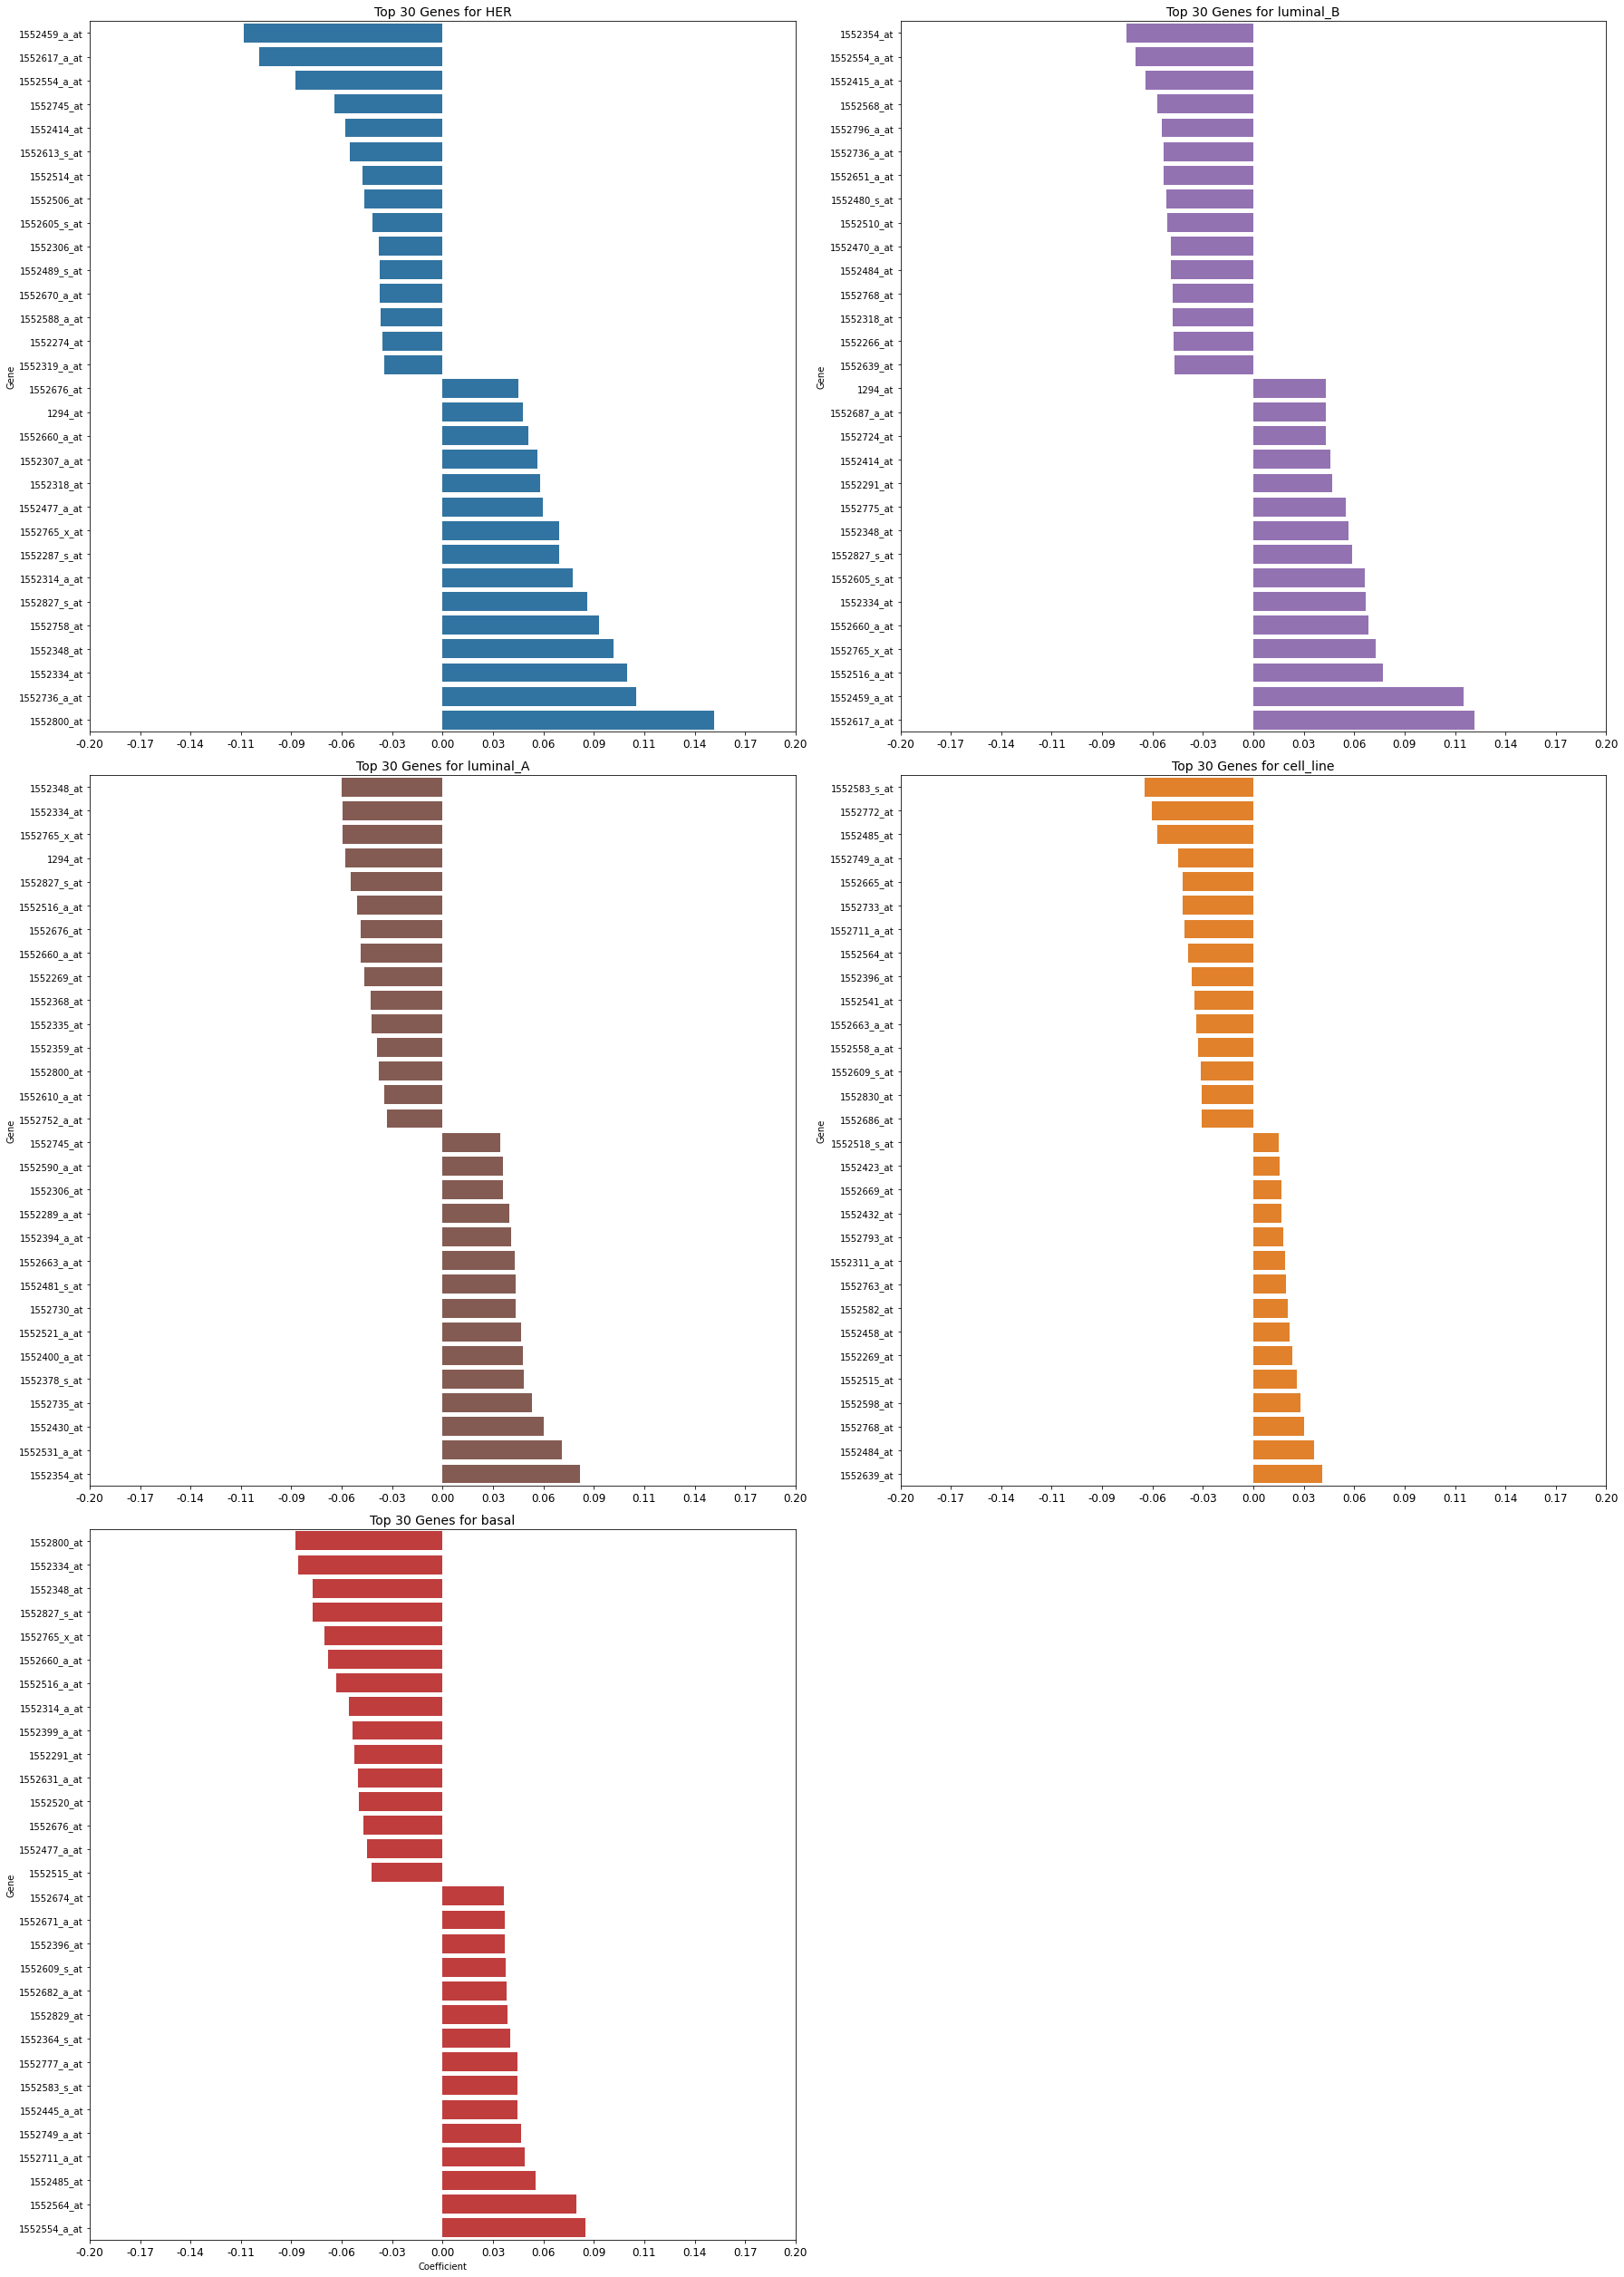

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(25, 35), sharex=True)
categories = ['HER', 'luminal_B', 'luminal_A', 'cell_line', 'basal']
coefficients = [her_coeffs, lumB_coeffs, lumA_coeffs, cellline_coeffs, basal_coeffs]


xticks = np.linspace(-0.2, 0.2, 15)
xtick_labels = [f"{x:.2f}" for x in xticks]

for i, (coef, category) in enumerate(zip(coefficients, categories)):
    ax = axes.flat[i]
    top_indices = list(np.argsort(coef)[-15:]) + list(np.argsort(coef)[:15])
    
    data = pd.DataFrame({'Gene': genes_names[top_indices], 'Coefficient': coef[top_indices]})
    sns.barplot(x='Coefficient', y='Gene', data=data.sort_values('Coefficient', ascending=True), ax=ax, palette=[color_map[category] for _ in range(30)])
    ax.set_title(f'Top 30 Genes for {category}', fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=12)
    ax.xaxis.set_tick_params(which='both', labelbottom=True) 

for j in range(i + 1, 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()